# Import Libraries

In [18]:
import pandas as pd
from pandas import DataFrame, Series

from bs4 import BeautifulSoup
from urllib.request import urlopen

from datetime import date, timedelta
import math
import scipy.stats as st
import scipy.special as sc
import numpy as np
from numpy import nan
from pprint import pprint

from basketball_reference_scraper.box_scores import get_box_scores
from basketball_reference_scraper.teams import get_team_misc
from basketball_reference_scraper.pbp import get_pbp

from nba_api.stats.static import teams
from nba_api.stats.endpoints import (
    leaguegamefinder,
    hustlestatsboxscore,
    boxscoreplayertrackv2,
    boxscoremiscv2,
)

import matplotlib.pyplot as plt
import seaborn as sns

import patsy

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Import Popularity Data

In [528]:
df_stg = []

start_date = date.fromisoformat("2019-10-22")
end_date = date.fromisoformat("2020-08-13")
days_gap = (end_date - start_date).days
dates_to_run = [start_date + timedelta(i) for i in range(days_gap)]

dates_to_run.remove(date.fromisoformat("2020-02-14"))
dates_to_run.remove(date.fromisoformat("2020-02-16"))

<IPython.core.display.Javascript object>

In [ ]:
for x in dates_to_run:
    url = 'https://wikihoops.com/games/' + str(x) + '/'
    try:
        html = urlopen(url)
    except:
        # skip if the url doesn't exist
        continue
    
    soup = BeautifulSoup(html, 'lxml')
    games = soup.find_all('article', class_='game')
    
    for i in games:
        upvotes = i.find('span', class_='upvotes-total').string
        downvotes = i.find('span', class_='downvotes-total').string

        home_team = i.find('span', itemprop='homeTeam')
        home_team_name = str(home_team.find('span', class_='team-city').string) \
                            + ' ' \
                            + str(home_team.find('span', class_='team-name').string)

        away_team = i.find('span', itemprop='awayTeam')
        away_team_name = str(away_team.find('span', class_='team-city').string) \
                            + ' ' \
                            + str(away_team.find('span', class_='team-name').string)

        df_stg.append({
            'home_team':home_team_name,
            'away_team':away_team_name,
            'upvotes':upvotes,
            'downvotes':downvotes,
            'date':str(x)
        })

In [468]:
ratings_df = DataFrame(df_stg)

NameError: name 'df_stg' is not defined

In [467]:
ratings_to_bball_ref_dict = {
    'Toronto Raptors':'TOR', 
    'Los Angeles Clippers':'LAC',
    'Charlotte Hornets':'CHO',
    'Orlando Magic':'ORL', 
    'Indiana Pacers':'IND', 
    'Philadelphia Sixers':'PHI',
    'Miami Heat':'MIA', 
    'Brooklyn Nets':'BKN', 
    'San Antonio Spurs':'SAS', 
    'Dallas Mavs':'DAL',
    'Utah Jazz':'UTA', 
    'Portland Blazers':'POR', 
    'Phoenix Suns':'PHO', 
    'Detroit Pistons':'DET',
    'Houston Rockets':'HOU', 
    'Golden State Warriors':'GSW', 
    'Boston Celtics':'BOS',
    'Memphis Grizzlies':'MEM', 
    'New Orleans Pelicans':'NOP',
    'Oklahoma City Thunder':'OKC', 
    'Denver Nuggets':'DEN', 
    'Sacramento Kings':'SAC',
    'Los Angeles Lakers':'LAL', 
    'Milwaukee Bucks':'MIL', 
    'New York Knicks':'NYK',
    'Atlanta Hawks':'ATL', 
    'Cleveland Cavs':'CLE', 
    'Chicago Bulls':'CHI',
    'Minnesota Wolves':'MIN', 
    'Washington Wizards':'WAS',
}

ratings_df['home_team'] = ratings_df['home_team'].map(lambda x: ratings_to_bball_ref_dict[x])
ratings_df['away_team'] = ratings_df['away_team'].map(lambda x: ratings_to_bball_ref_dict[x])

KeyError: 'TOR'

In [235]:
ratings_df.to_csv('ratings_df.csv', index=False)
ratings_df.head()

,home_team,away_team,upvotes,downvotes,date
0,TOR,NOP,262,33,2019-10-22
1,LAC,LAL,204,47,2019-10-22
2,CHO,CHI,52,8,2019-10-23
3,ORL,CLE,7,11,2019-10-23
4,IND,DET,12,0,2019-10-23


# Import Game Data

In [438]:
box_score_totals = []

for i in ratings_df.itertuples():
    try:
        box = get_box_scores(i.date, i.home_team, i.away_team)
        
        home_team_df = box[i.home_team]
        home_team_box = home_team_df[home_team_df['PLAYER'] == 'Team Totals'].iloc[0,:].to_dict()

        away_team_df = box[i.away_team]
        away_team_box = away_team_df[away_team_df['PLAYER'] == 'Team Totals'].iloc[0,:].to_dict()
        
        pt20_scorers = len([i for i in home_team_df.loc[home_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>20]) + \
                            len([i for i in away_team_df.loc[away_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>20])
        
        pt30_scorers = len([i for i in home_team_df.loc[home_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>30]) + \
                            len([i for i in away_team_df.loc[away_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>30])
        
        pt40_scorers = len([i for i in home_team_df.loc[home_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>40]) + \
                            len([i for i in away_team_df.loc[away_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>40])
        
        pt50_scorers = len([i for i in home_team_df.loc[home_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>50]) + \
                            len([i for i in away_team_df.loc[away_team_df['PLAYER'] != 'Team Totals', 'PTS'] 
                                 if i.isnumeric() and int(i)>50])
        
        box_score_totals.append({
            'home_team':i.home_team,
            'away_team':i.away_team,
            'date':i.date,
            'home_team_box':home_team_box,
            'away_team_box':away_team_box,
            'pt20_scorers':pt20_scorers,
            'pt30_scorers':pt30_scorers,
            'pt40_scorers':pt40_scorers,
            'pt50_scorers':pt50_scorers,
        })
    except:
        continue

In [439]:
box_score_totals_df = DataFrame(box_score_totals)
box_score_totals_df.to_csv('box_score_totals_df.csv', index=False)
box_score_totals_df.head()

,home_team,away_team,date,home_team_box,away_team_box,pt20_scorers,pt30_scorers,pt40_scorers,pt50_scorers
0,TOR,NOP,2019-10-22,"{'PLAYER': 'Team Totals', 'MP': '265', 'FG': '...","{'PLAYER': 'Team Totals', 'MP': '265', 'FG': '...",4,2,0,0
1,LAC,LAL,2019-10-22,"{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...","{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...",4,0,0,0
2,CHO,CHI,2019-10-23,"{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...","{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...",4,1,0,0
3,ORL,CLE,2019-10-23,"{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...","{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...",1,0,0,0
4,IND,DET,2019-10-23,"{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...","{'PLAYER': 'Team Totals', 'MP': '240', 'FG': '...",5,1,0,0


In [534]:
pbp_list = []


def clock_to_elapsed_time(x):
    clock_split = [float(x) for x in x.split(":")]
    return round((11 - clock_split[0]) + (60 - clock_split[1]) / 60.0, 4)


for i in ratings_df.itertuples():
    try:
        pbp = get_pbp(i.date, i.home_team, i.away_team)

        elapsed_time = pbp["QUARTER"].map(
            lambda x: (int(x.replace("OT", "")) - 1) * 5 + 48
            if type(x) == type("")
            else (x - 1) * 12
        ) + pbp["TIME_REMAINING"].map(clock_to_elapsed_time)
        + pbp['QUARTER'].map(lambda x: -7*int(x.replace("OT", "")) if type(x)==type('') else 0)

        score_dict = dict(zip(elapsed_time, pbp.iloc[:, 5] - pbp.iloc[:, 4]))

        pbp_list.append(
            {
                "home_team": i.home_team,
                "away_team": i.away_team,
                "date": i.date,
                "score_dict": score_dict,
            }
        )
    except:
        continue

<IPython.core.display.Javascript object>

In [535]:
pbp_df = DataFrame(pbp_list)
pbp_df.to_csv("pbp_df.csv", index=False)
pbp_df.head()

,home_team,away_team,date,score_dict
0,TOR,NOP,2019-10-22,"{0.2: 0, 0.2167: -2, 0.5167: -2, 0.5833: -2, 0..."
1,LAC,LAL,2019-10-22,"{0.2167: -2, 0.3333: -2, 0.3667: -2, 0.6167: -..."
2,CHO,CHI,2019-10-23,"{0.3667: 0, 0.4: 0, 0.65: 0, 0.7: 0, 0.7833: 0..."
3,ORL,CLE,2019-10-23,"{0.25: 0, 0.3167: 0, 0.5: -2, 0.7: 1, 1.1167: ..."
4,IND,DET,2019-10-23,"{0.2667: 0, 0.3167: 0, 0.4: 0, 0.45: 0, 0.6833..."


<IPython.core.display.Javascript object>

In [351]:
team_misc_stats = []

for team in ratings_to_bball_ref_dict.values():
    try:
        stats = get_team_misc(team, 2020)
        team_misc_stats.append({
            'team':team,
            'wins':82*stats['W']/(stats['W']+stats['L']),
            'p_wins':82*stats['PW']/(stats['PW']+stats['PL']),
            'SRS':stats['SRS'],
        })
    except:
        continue

In [352]:
team_misc_stats_df = DataFrame(team_misc_stats)
team_misc_stats_df.to_csv('team_misc_stats_df.csv', index=False)
team_misc_stats_df.head()

,team,wins,p_wins,SRS
0,TOR,60.361111,56.944444,5.97
1,LAC,55.805556,56.944444,6.66
2,CHO,29.015385,23.969231,-7.03
3,ORL,37.068493,38.191781,-0.93
4,IND,50.547945,46.054795,1.63


In [9]:
accolades = {
    "TOR": 2,
    "LAC": 1,
    "CHO": 0,
    "ORL": 0,
    "IND": 1,
    "PHI": 2,
    "MIA": 2,
    "BKN": 0,
    "SAS": 0,
    "DAL": 1,
    "UTA": 2,
    "POR": 1,
    "PHO": 1,
    "DET": 0,
    "HOU": 2,
    "GSW": 0,
    "BOS": 2,
    "MEM": 0,
    "NOP": 1,
    "OKC": 1,
    "DEN": 1,
    "SAC": 0,
    "LAL": 2,
    "MIL": 2,
    "NYK": 0,
    "ATL": 1,
    "CLE": 0,
    "CHI": 0,
    "MIN": 0,
    "WAS": 0,
}

accolades_df = (
    DataFrame(accolades, index=["num_all_stars"])
    .T.reset_index()
    .rename(columns={"index": "team"})
)
accolades_df.to_csv("accolades_df.csv", index=False)
accolades_df.head()

,team,num_all_stars
0,TOR,2
1,LAC,1
2,CHO,0
3,ORL,0
4,IND,1


<IPython.core.display.Javascript object>

# Import NBA Stats Game Data

In [503]:
nba_teams = teams.get_teams()
nba_teams_id_dict = dict(
    zip([i["abbreviation"] for i in nba_teams], [i["id"] for i in nba_teams])
)


def to_nba_team_id(abbrv, dictionary):
    if abbrv == "CHO":
        abbrv = "CHA"
    elif abbrv == "PHO":
        abbrv = "PHX"
    return dictionary[abbrv]


nba_stats_list = []

for i in ratings_df.itertuples():
    try:
        game_id_df = leaguegamefinder.LeagueGameFinder(
            team_id_nullable=to_nba_team_id(i.home_team, nba_teams_id_dict),
            vs_team_id_nullable=to_nba_team_id(i.away_team, nba_teams_id_dict),
            season_nullable="2019-20",
        ).get_data_frames()[0]

        game_id = game_id_df[game_id_df["GAME_DATE"] == i.date].GAME_ID.min()

        hustle = (
            hustlestatsboxscore.HustleStatsBoxScore(game_id)
            .team_stats.get_data_frame()
            .sum()
        )

        misc = (
            boxscoremiscv2.BoxScoreMiscV2(game_id).sql_teams_misc.get_data_frame().sum()
        )

        tracking = (
            boxscoreplayertrackv2.BoxScorePlayerTrackV2(game_id)
            .team_stats.get_data_frame()
            .sum()
        )

        nba_stats_list.append(
            {
                "home_team": i.home_team,
                "away_team": i.away_team,
                "date": i.date,
                "deflections": hustle["DEFLECTIONS"],
                "charges_drawn": hustle["CHARGES_DRAWN"],
                "screen_assists": hustle["SCREEN_ASSISTS"],
                "loose_balls_recovered": hustle["LOOSE_BALLS_RECOVERED"],
                "box_outs": hustle["BOX_OUTS"],
                "pts_off_tov": misc["PTS_OFF_TOV"],
                "second_chance_pts": misc["PTS_2ND_CHANCE"],
                "fastbreak_pts": misc["PTS_FB"],
                "pts_in_paint": misc["PTS_PAINT"],
                "distance_run": tracking["DIST"],
                "hocket_assists": tracking["SAST"],
                "total_passes": tracking["PASS"],
            }
        )
    except:
        print("wtf!")
        continue

wtf!
wtf!


<IPython.core.display.Javascript object>

In [504]:
nba_stats_df = DataFrame(nba_stats_list)
nba_stats_df.to_csv("nba_stats_df.csv", index=False)
nba_stats_df.head()

,home_team,away_team,date,deflections,charges_drawn,screen_assists,loose_balls_recovered,box_outs,pts_off_tov,second_chance_pts,fastbreak_pts,pts_in_paint,distance_run,hocket_assists,total_passes
0,TOR,NOP,2019-10-22,39,8,15,18,42,42.0,28.0,33.0,94.0,40.29,11,742
1,LAC,LAL,2019-10-22,34,4,14,23,46,42.0,18.0,27.0,82.0,33.48,6,557
2,CHO,CHI,2019-10-23,23,2,10,17,20,42.0,29.0,46.0,120.0,37.71,7,600
3,ORL,CLE,2019-10-23,21,2,25,8,37,22.0,15.0,24.0,92.0,36.09,6,575
4,IND,DET,2019-10-23,38,1,18,14,26,31.0,36.0,20.0,96.0,35.62,4,592


<IPython.core.display.Javascript object>

# Wilson lower bounds + Bayesian average rating

In [3]:
# So you don't need to run the above section again, since it's saved locally
ratings_df = pd.read_csv("ratings_df.csv")

<IPython.core.display.Javascript object>

In [4]:
ratings_df["totalvotes"] = ratings_df["upvotes"] + ratings_df["downvotes"]

<IPython.core.display.Javascript object>

In [5]:
def wilson_lower_bound(pos, n, confidence=0.95):
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (
        phat
        + z * z / (2 * n)
        - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)
    ) / (1 + z * z / n)


ratings_df["wlb"] = ratings_df.apply(
    lambda row: wilson_lower_bound(row["upvotes"], row["totalvotes"]), axis=1
)
ratings_df.sort_values("wlb", ascending=False).head(10)

,home_team,away_team,upvotes,downvotes,date,totalvotes,wlb
36,MEM,BKN,59,0,2019-10-27,59,0.938871
73,DAL,LAL,126,3,2019-11-01,129,0.933856
225,CHO,CHI,89,2,2019-11-23,91,0.923368
891,BOS,HOU,71,2,2020-02-29,73,0.905499
457,LAL,LAC,70,2,2019-12-25,72,0.904258
83,POR,PHI,70,2,2019-11-02,72,0.904258
7,BKN,MIN,65,2,2019-10-23,67,0.897534
975,POR,MEM,50,1,2020-07-31,51,0.896954
1025,DAL,MIL,32,0,2020-08-08,32,0.892821
223,LAC,HOU,60,2,2019-11-22,62,0.889795


<IPython.core.display.Javascript object>

In [6]:
def bayesian_lower_bound(pos, neg, confidence=0.95):
    return st.beta.ppf((1 - confidence) / 2, pos + 0.5, neg + 0.5)
    # Below is a lower bound weighted so that ranking a "bad" game high is 5x worse than the opposite
    # return sc.betaincinv(pos+0.5, neg+0.5, 1/5)


ratings_df["blb"] = ratings_df.apply(
    lambda row: bayesian_lower_bound(row["upvotes"], row["downvotes"]), axis=1
)

ratings_df.sort_values("blb", ascending=False).head(10)

,home_team,away_team,upvotes,downvotes,date,totalvotes,wlb,blb
36,MEM,BKN,59,0,2019-10-27,59,0.938871,0.958491
73,DAL,LAL,126,3,2019-11-01,129,0.933856,0.939247
225,CHO,CHI,89,2,2019-11-23,91,0.923368,0.931369
1025,DAL,MIL,32,0,2020-08-08,32,0.892821,0.925072
891,BOS,HOU,71,2,2020-02-29,73,0.905499,0.915013
83,POR,PHI,70,2,2019-11-02,72,0.904258,0.913873
457,LAL,LAC,70,2,2019-12-25,72,0.904258,0.913873
975,POR,MEM,50,1,2020-07-31,51,0.896954,0.912007
7,BKN,MIN,65,2,2019-10-23,67,0.897534,0.907681
32,SAS,WAS,24,0,2019-10-26,24,0.862024,0.901612


<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Wilson lower bound is a good estimate')

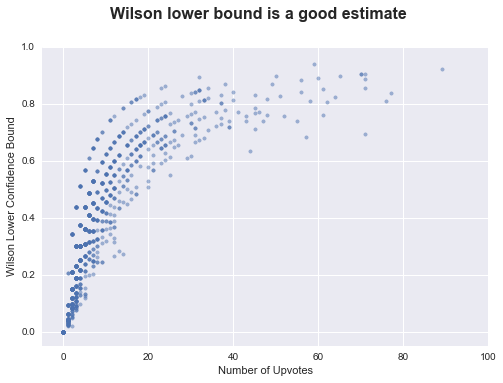

<IPython.core.display.Javascript object>

In [7]:
plt.style.use("seaborn")
fig, ax = plt.subplots()

ax.scatter(ratings_df["upvotes"], ratings_df["wlb"], alpha=0.5, marker=".")

ax.set(
    ylabel="Wilson Lower Confidence Bound",
    xlabel="Number of Upvotes",
    xlim=(-5, 100),
    ylim=(-0.05, 1),
)

fig.suptitle("Wilson lower bound is a good estimate", fontsize=16, fontweight="bold")

Text(0.5, 0.98, 'Bayesian lower bound is basically the same')

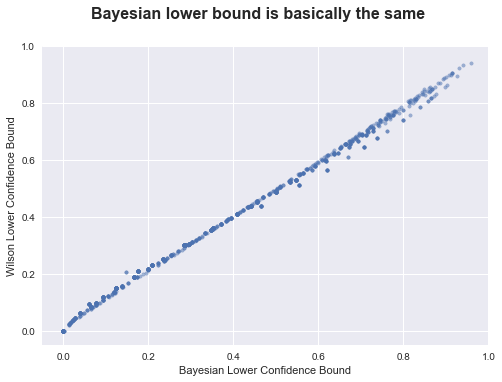

<IPython.core.display.Javascript object>

In [8]:
plt.style.use("seaborn")
fig, ax = plt.subplots()

ax.scatter(ratings_df["blb"], ratings_df["wlb"], alpha=0.5, marker=".")

ax.set(
    ylabel="Wilson Lower Confidence Bound",
    xlabel="Bayesian Lower Confidence Bound",
    xlim=(-0.05, 1),
    ylim=(-0.05, 1),
)

fig.suptitle(
    "Bayesian lower bound is basically the same", fontsize=16, fontweight="bold"
)

In [9]:
ratings_df["popularity"] = ratings_df["wlb"] * 10

<IPython.core.display.Javascript object>

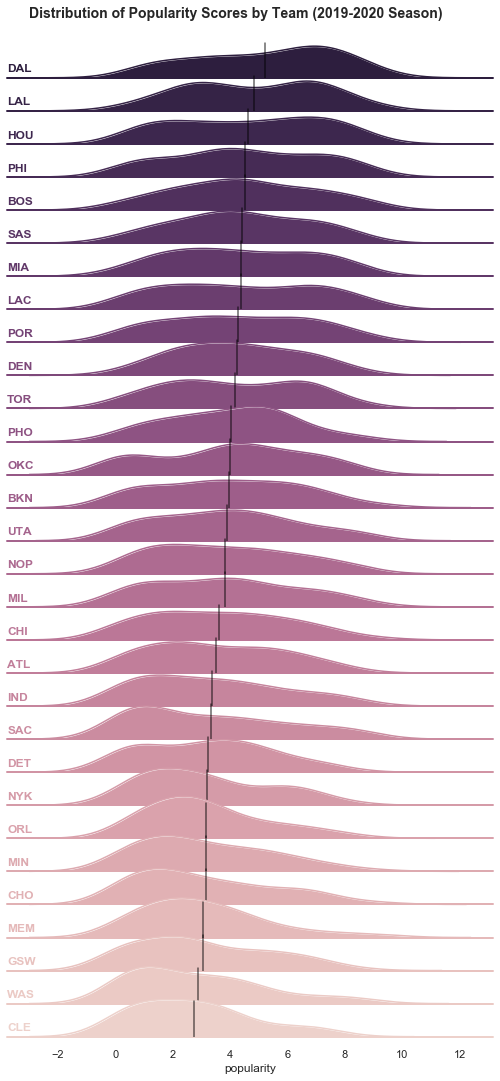

<IPython.core.display.Javascript object>

In [568]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

plot_df = pd.concat(
    [
        ratings_df[["home_team", "popularity"]].rename(columns={"home_team": "team"}),
        ratings_df[["away_team", "popularity"]].rename(columns={"away_team": "team"}),
    ]
).reset_index(drop=True)

plot_df["sort_val"] = plot_df.apply(
    lambda row: plot_df[plot_df["team"] == row["team"]].mean(), axis=1
)
plot_df.sort_values("sort_val", ascending=False, inplace=True)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(n_colors=30, reverse=True)
g = sns.FacetGrid(plot_df, row="team", hue="team", aspect=15, height=0.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "popularity", clip_on=False, shade=True, alpha=1, lw=1.5, bw=1)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )
    ax.axvline(x=x.mean(), ymax=0.8, color="black", alpha=0.6)


g.map(label, "popularity")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.suptitle(
    "Distribution of Popularity Scores by Team (2019-2020 Season)",
    fontweight="bold",
    fontsize=14,
    y=1,
)

plt.savefig("popularity_dist.png", dpi=400, bbox_inches="tight")

# Process Game Data and Join Ratings

In [19]:
# So you don't need to run the above section again, since it's saved locally
box_score_totals_df = pd.read_csv("box_score_totals_df.csv")
team_misc_stats_df = pd.read_csv("team_misc_stats_df.csv")
accolades_df = pd.read_csv("accolades_df.csv")
pbp_df = pd.read_csv("pbp_df.csv")
nba_stats_df = pd.read_csv("nba_stats_df.csv")

<IPython.core.display.Javascript object>

In [20]:
box_score_totals_df["home_team_box"] = box_score_totals_df["home_team_box"].map(
    lambda x: eval(x)
)
box_score_totals_df["away_team_box"] = box_score_totals_df["away_team_box"].map(
    lambda x: eval(x)
)
pbp_df["score_dict"] = pbp_df["score_dict"].map(lambda x: eval(x))

<IPython.core.display.Javascript object>

In [21]:
team_df = team_misc_stats_df.merge(
    accolades_df.set_index("team"), how="inner", left_on="team", right_index=True
)

<IPython.core.display.Javascript object>

In [22]:
df = ratings_df.merge(
    team_df.set_index("team").rename(
        columns={
            "wins": "home_wins",
            "p_wins": "home_p_wins",
            "SRS": "home_SRS",
            "num_all_stars": "home_num_all_stars",
        }
    ),
    how="left",
    left_on="home_team",
    right_index=True,
)

df = df.merge(pbp_df, how="left", on=["home_team", "away_team", "date"])

df = df.merge(
    team_df.set_index("team").rename(
        columns={
            "wins": "away_wins",
            "p_wins": "away_p_wins",
            "SRS": "away_SRS",
            "num_all_stars": "away_num_all_stars",
        }
    ),
    how="left",
    left_on="away_team",
    right_index=True,
)

df = df.merge(nba_stats_df, how="left", on=["home_team", "away_team", "date"])

<IPython.core.display.Javascript object>

In [23]:
df = df.merge(
    box_score_totals_df, how="left", on=["home_team", "away_team", "date"]
).dropna()

<IPython.core.display.Javascript object>

In [24]:
for i in [
    "FG",
    "FGA",
    "3P",
    "3PA",
    "FT",
    "FTA",
    "ORB",
    "DRB",
    "TRB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PF",
    "PTS",
]:
    df["total_" + i] = df.home_team_box.map(lambda x: int(x[i])) + df.away_team_box.map(
        lambda x: int(x[i])
    )

df["total_FGP"] = df["total_FG"] / df["total_FGA"]
df["total_3PP"] = df["total_3P"] / df["total_3PA"]
df["total_FTP"] = df["total_FT"] / df["total_FTA"]
df["total_TSP"] = df["total_PTS"] / (2 * df["total_FGA"] + 0.88 * df["total_FTA"])
df["total_TSA"] = df["total_PTS"] / df["total_TSP"]

df["MOV"] = abs(
    df.home_team_box.map(lambda x: int(x["PTS"]))
    - df.away_team_box.map(lambda x: int(x["PTS"]))
)
df["num_overtimes"] = df.home_team_box.map(lambda x: (int(x["MP"]) - 48 * 5) / (5 * 5))
df["has_overtime"] = df.home_team_box.map(lambda x: 1 if int(x["MP"]) > 48 * 5 else 0)

df["avg_wins"] = 0.5 * (df["home_wins"] + df["away_wins"])
df["avg_p_wins"] = 0.5 * (df["home_p_wins"] + df["away_p_wins"])
df["avg_SRS"] = 0.5 * (df["home_SRS"] + df["away_SRS"])

df["wins_gap"] = abs(df["home_wins"] - df["away_wins"])
df["p_wins_gap"] = abs(df["home_p_wins"] - df["away_p_wins"])
df["SRS_gap"] = abs(df["home_SRS"] - df["away_SRS"])

df["total_all_stars"] = df["away_num_all_stars"] + df["home_num_all_stars"]

<IPython.core.display.Javascript object>

In [25]:
for i in df["home_team"].unique():
    df["has_" + i] = 1 * (
        df["home_team"].map(lambda x: True if x == i else False)
        | df["away_team"].map(lambda x: True if x == i else False)
    )

<IPython.core.display.Javascript object>

In [26]:
# do stuff with pbp


def score_dict_to_avg_margin(x, time="all"):
    if time == "all":
        x[0] = 0
        times = sorted([0] + [i for i in x.keys()])
    elif time == "4th":
        x = {key: value for key, value in x.items() if key >= 36 and key < 48}
        times = sorted([i for i in x.keys()])

    acc = 0
    for i in range(1, len(times)):
        acc += abs(x[times[i - 1]]) * (times[i] - times[i - 1])

    return acc / max(times)


def score_dict_to_lead_changes(x, time="all"):
    if time == "all":
        pass
    elif time == "4th":
        x = {key: value for key, value in x.items() if key >= 36 and key < 48}
    current_lead = 0
    lead_changes = 0
    for score in x.values():
        if score > 0 and current_lead == -1:
            lead_changes += 1
            current_lead = 1
        elif score < 0 and current_lead == 1:
            lead_changes += 1
            current_lead = -1
        elif score > 0 and current_lead == 0:
            current_lead = 1
        elif score < 0 and current_lead == 0:
            current_lead = -1
    return lead_changes


def score_dict_to_point_swing(x, start=0, end=48):
    x = {key: value for key, value in x.items() if key >= start and key <= end}
    starting_value = x[min(x.keys())]
    ending_value = x[max(x.keys())]
    return abs(ending_value - starting_value)


def score_dict_to_largest_combeback(x):
    starting_value = x[min(x.keys())]
    ending_value = x[max(x.keys())]
    return abs(ending_value - starting_value)


def score_dict_to_largest_comeback(x, start=0, end=100):
    x = {key: value for key, value in x.items() if key >= start and key < end}

    current_lead = 0
    largest_comeback = 0
    for score in x.values():
        #         print(score, current_lead)
        if score == 0:
            pass
        elif (score > 0 and score > current_lead and current_lead >= 0) or (
            score < 0 and score < current_lead and current_lead <= 0
        ):
            current_lead = score
        elif (score > 0 and current_lead < 0) or (score < 0 and current_lead > 0):
            if abs(current_lead) > largest_comeback:
                largest_comeback = abs(current_lead)
            current_lead = score
    return largest_comeback


df["avg_margin"] = df["score_dict"].apply(score_dict_to_avg_margin, time="all")

df["num_lead_changes"] = df["score_dict"].apply(score_dict_to_lead_changes, time="all")
df["num_4th_qtr_lead_changes"] = df["score_dict"].apply(
    score_dict_to_lead_changes, time="4th"
)

df["score_change_1st_qtr"] = df["score_dict"].apply(
    score_dict_to_point_swing, start=0, end=12
)
df["score_change_2nd_qtr"] = df["score_dict"].apply(
    score_dict_to_point_swing, start=12, end=24
)
df["score_change_3rd_qtr"] = df["score_dict"].apply(
    score_dict_to_point_swing, start=24, end=36
)
df["score_change_4th_qtr"] = df["score_dict"].apply(
    score_dict_to_point_swing, start=36, end=48
)

df["largest_comeback"] = df["score_dict"].apply(
    score_dict_to_largest_comeback, start=0, end=48
)
df["largest_4th_qtr_comeback"] = df["score_dict"].apply(
    score_dict_to_largest_comeback, start=36, end=48
)

df["largest_score_difference"] = df["score_dict"].map(
    lambda x: abs(min(x.values()) - max(x.values()))
)

<IPython.core.display.Javascript object>

In [27]:
df.head()

,home_team,away_team,upvotes,downvotes,date,totalvotes,wlb,blb,popularity,home_wins,...,avg_margin,num_lead_changes,num_4th_qtr_lead_changes,score_change_1st_qtr,score_change_2nd_qtr,score_change_3rd_qtr,score_change_4th_qtr,largest_comeback,largest_4th_qtr_comeback,largest_score_difference
0,TOR,NOP,262,33,2019-10-22,295,0.847063,0.848411,8.470631,60.361111,...,3.082364,15,5,3,2,7,2,11,6,19
1,LAC,LAL,204,47,2019-10-22,251,0.759907,0.761058,7.599067,55.805556,...,6.365455,5,0,3,11,8,10,14,0,25
2,CHO,CHI,52,8,2019-10-23,60,0.758348,0.764129,7.583484,29.015385,...,5.103271,11,2,9,1,7,0,16,10,26
3,ORL,CLE,7,11,2019-10-23,18,0.203052,0.193813,2.030525,37.068493,...,9.148685,11,0,4,10,8,1,4,0,22
4,IND,DET,12,0,2019-10-23,12,0.757506,0.814694,7.575060,50.547945,...,3.277637,8,3,3,4,2,12,9,4,19


<IPython.core.display.Javascript object>

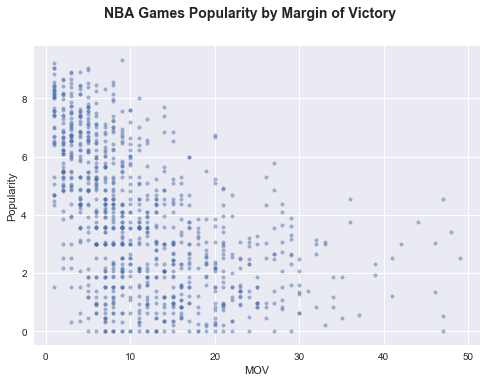

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots()

ax.scatter(df.MOV, df.popularity, alpha=0.5, marker=".")

ax.set(
    ylabel="Popularity", xlabel="MOV",
)
fig.suptitle(
    "NBA Games Popularity by Margin of Victory", fontweight="bold", fontsize=14,
)

plt.savefig("popularity_by_mov.png", dpi=400, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 9))

corr = (
    df[[i for i in df.columns if "has" not in i and "total" not in i]]
    .loc[:, "popularity":]
    .corr()
)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap="RdYlBu", center=0, square=True, linewidths=0.5)

b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

# Everything OLS

In [544]:
all_variables = [
    i
    for i in df.loc[:, "deflections":].columns
    if i
    not in [
        "num_overtimes",
        "avg_SRS",
        "SRS_gap",
        "avg_p_wins",
        "p_wins_gap",
        "home_team_box",
        "away_team_box",
    ]
] + ["MOV^2", "MOV^3",]

y, X = patsy.dmatrices(
    "popularity~-1+" + "".join(["+" + i for i in all_variables]), df,
)

everything_model = LinearRegression().fit(X, y)
everything_r2 = cross_val_score(
    everything_model, X, y, cv=ShuffleSplit(n_splits=1000, test_size=0.2), scoring="r2",
).mean()

print(
    "Everything OLS CV R2: ", (100 * everything_r2).round(1), "%", sep="",
)

Everything OLS CV R2: 44.2%


<IPython.core.display.Javascript object>

# Forward Stepwise OLS

In [555]:
f_base = "popularity~1"
all_variables = [
    i
    for i in df.loc[:, "deflections":].columns
    if i
    not in [
        "num_overtimes",
        "avg_SRS",
        "SRS_gap",
        "avg_p_wins",
        "p_wins_gap",
        "home_team_box",
        "away_team_box",
    ]
] + ["MOV^2", "MOV^3",]

cv_iterations = 2000
current_variables = []
best_model_found = 0

current_f = f_base + "".join(["+" + i for i in current_variables])
y, X = patsy.dmatrices(current_f, df)

current_r2 = cross_val_score(
    LinearRegression(),
    X,
    y,
    cv=ShuffleSplit(n_splits=cv_iterations, test_size=0.2),
    scoring="r2",
).mean()
changes_dict = {}

while best_model_found == 0:
    possible_changes = {}

    for add_var in list(set(all_variables) - set(current_variables)):
        test_f = f_base + "".join(["+" + i for i in current_variables]) + "+" + add_var
        y, X = patsy.dmatrices(test_f, df)

        test_r2s = cross_val_score(
            LinearRegression(),
            X,
            y,
            cv=ShuffleSplit(n_splits=cv_iterations, test_size=0.2),
            scoring="r2",
        )
        test_r2 = test_r2s.mean()
        test_r2_error = (test_r2s.std() / np.sqrt(len(test_r2s))) * 1.96

        if test_r2 > current_r2:
            possible_changes[add_var] = {"r2": test_r2, "error": test_r2_error}

    if len(possible_changes) == 0:
        best_model_found = 1
    else:
        best_change = max(possible_changes, key=lambda x: possible_changes[x]["r2"])
        best_r2 = possible_changes[best_change]["r2"]

        if best_r2 > current_r2:
            current_variables.append(best_change)
            current_r2 = best_r2
            changes_dict[best_change] = possible_changes[best_change]
        else:
            best_model_found = 1
    if best_model_found == 0:
        print(
            "Formula: ",
            f_base + "+" + "\n\t\t+".join(current_variables),
            " \nR2: ",
            np.round(best_r2 * 100, 1),
            "%\n",
            sep="",
        )

print("Done")

stepwise_f = f_base + "".join(["+" + i for i in current_variables])

Formula: popularity~1+MOV 
R2: 25.2%

Formula: popularity~1+MOV
		+total_all_stars 
R2: 32.6%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback 
R2: 38.1%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers 
R2: 41.4%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers
		+has_overtime 
R2: 43.8%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers
		+has_overtime
		+has_DAL 
R2: 45.2%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers
		+has_overtime
		+has_DAL
		+num_4th_qtr_lead_changes 
R2: 46.1%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers
		+has_overtime
		+has_DAL
		+num_4th_qtr_lead_changes
		+has_LAC 
R2: 46.8%

Formula: popularity~1+MOV
		+total_all_stars
		+largest_4th_qtr_comeback
		+pt30_scorers
		+has_overtime
		+has_DAL
		+num_4th_qtr_lead_changes
		+has_

<IPython.core.display.Javascript object>

In [556]:
y, X = patsy.dmatrices(stepwise_f, df)

stepwise_model = LinearRegression().fit(X, y)
stepwise_r2 = cross_val_score(
    stepwise_model, X, y, cv=ShuffleSplit(n_splits=1000, test_size=0.2), scoring="r2",
).mean()

print(
    "Stepwise OLS CV R2: ", (100 * stepwise_r2).round(1), "%", sep="",
)

Stepwise OLS CV R2: 48.8%


<IPython.core.display.Javascript object>

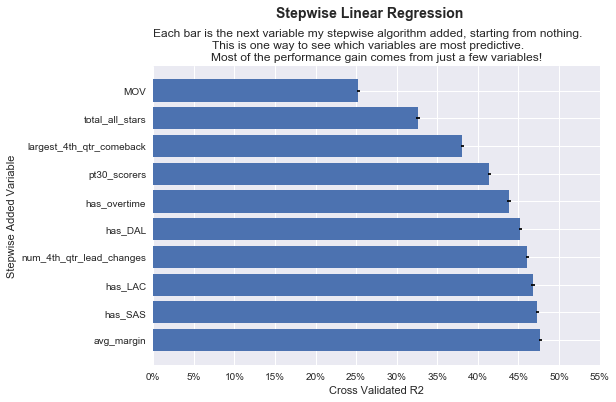

<IPython.core.display.Javascript object>

In [567]:
fig, ax = plt.subplots()

top_n = 10
var_keys = list(changes_dict.keys())[:top_n]
var_values = [i["r2"] for i in changes_dict.values()][:top_n]
var_errors = [i["error"] for i in changes_dict.values()][:top_n]

ax.barh(
    var_keys, var_values, xerr=var_errors,
)
xticks = range(0, 60, 5)
ax.set(
    title="Each bar is the next variable my stepwise algorithm added, starting from nothing. \
    \nThis is one way to see which variables are most predictive. \
    \nMost of the performance gain comes from just a few variables!",
    ylabel="Stepwise Added Variable",
    xlabel="Cross Validated R2",
    xticks=[i / 100 for i in xticks],
    xticklabels=[str(i) + "%" for i in xticks],
)
fig.suptitle("Stepwise Linear Regression", fontweight="bold", fontsize=14, y=1.03)

fig.gca().invert_yaxis()

plt.savefig("stepwise.png", dpi=400, bbox_inches="tight")

# Bootstrapped LASSO

In [559]:
all_variables = [
    i
    for i in df.loc[:, "deflections":].columns
    if i
    not in [
        "num_overtimes",
        "avg_SRS",
        "SRS_gap",
        "avg_p_wins",
        "p_wins_gap",
        "home_team_box",
        "away_team_box",
    ]
] + ["MOV^2", "MOV^3",]
lasso_f = "popularity~-1+" + "+".join(all_variables)

coef_dict = {i: [] for i in all_variables}
intercept_list = []
cv_r2_list = []

y, X = patsy.dmatrices(lasso_f, df, return_type="dataframe")

iters = 2000
for boot in range(iters):
    boot_df = pd.concat([y, X], axis=1).sample(frac=1, replace=True)
    boot_y = boot_df.iloc[:, 0]
    boot_X = boot_df.iloc[:, 1:]

    alpha_list = np.linspace(0, 0.01, 20)[1:]
    score_list = []

    for i in alpha_list:
        scores = cross_val_score(
            Lasso(alpha=i, max_iter=10000, selection="random", normalize=True,),
            boot_X,
            boot_y,
            cv=ShuffleSplit(n_splits=50, test_size=0.2),
            scoring="r2",
        )
        score_list.append({"alpha": i, "score": np.mean(scores), "var": np.std(scores)})

    best_theta = max(score_list, key=lambda x: x["score"])
    chosen_theta = min(
        [
            i
            for i in score_list
            if i["alpha"] > best_theta["alpha"]
            and i["score"] < best_theta["score"] - best_theta["var"]
        ],
        key=lambda x: x["alpha"],
    )

    boot_model = Lasso(
        alpha=chosen_theta["alpha"],
        max_iter=1000000,
        selection="random",
        normalize=True,
    ).fit(boot_X, boot_y)

    intercept_list.append(boot_model.intercept_)
    cv_r2_list.append(chosen_theta["score"])

    coefs = dict(zip(all_variables, boot_model.coef_))
    for var, est in coefs.items():
        coef_dict[var] = coef_dict[var] + [est]

    if 100 * (1 + boot) / iters in range(0, 110, 10):
        print(
            "Percentage Done: ",
            int(100 * (boot + 1) / iters),
            "% (",
            boot + 1,
            " iterations)",
            sep="",
        )

Percentage Done: 10% (200 iterations)
Percentage Done: 20% (400 iterations)
Percentage Done: 30% (600 iterations)
Percentage Done: 40% (800 iterations)
Percentage Done: 50% (1000 iterations)
Percentage Done: 60% (1200 iterations)
Percentage Done: 70% (1400 iterations)
Percentage Done: 80% (1600 iterations)
Percentage Done: 90% (1800 iterations)
Percentage Done: 100% (2000 iterations)


<IPython.core.display.Javascript object>

In [560]:
print(
    "LASSO Linear Regression Model CV R2: ",
    (100 * np.mean(cv_r2_list)).round(1),
    "%",
    sep="",
)

LASSO Linear Regression Model CV R2: 45.6%


<IPython.core.display.Javascript object>

In [561]:
def check_stat_sig(vals):
    lower = np.percentile(vals, 2.5)
    upper = np.percentile(vals, 97.5)
    if (lower > 0 and upper > 0) or (lower < 0 and upper < 0):
        return np.percentile(vals, 50), lower, upper
    else:
        return 0, lower, upper


ss_coef_list = []
for key, val in coef_dict.items():
    est, lower, upper = check_stat_sig(val)
    if est != 0:
        ss_coef_list.append(
            {
                "Variable": key,
                "Coefficient": est.round(3),
                "Confidence Interval (95%)": "("
                + str(lower.round(3))
                + ", "
                + str(upper.round(3))
                + ")",
            }
        )

DataFrame(ss_coef_list).sort_values("Coefficient", ascending=False)

,Variable,Coefficient,Confidence Interval (95%)
2,has_overtime,1.035,"(0.565, 1.465)"
0,pt30_scorers,0.286,"(0.124, 0.447)"
3,total_all_stars,0.233,"(0.053, 0.409)"
4,num_4th_qtr_lead_changes,0.091,"(0.02, 0.165)"
5,largest_4th_qtr_comeback,0.072,"(0.03, 0.111)"
1,MOV,-0.077,"(-0.097, -0.046)"


<IPython.core.display.Javascript object>

# Random Forest Variable Importance

In [545]:
all_variables = [
    i
    for i in df.loc[:, "deflections":].columns
    if i
    not in [
        "num_overtimes",
        "avg_SRS",
        "SRS_gap",
        "avg_p_wins",
        "p_wins_gap",
        "home_team_box",
        "away_team_box",
    ]
] + ["MOV^2", "MOV^3",]
forest_f = "popularity~-1+" + "+".join(all_variables)

<IPython.core.display.Javascript object>

In [546]:
y, X = patsy.dmatrices(forest_f, df)

forest_model = RandomForestRegressor(
    max_depth=3, n_estimators=50, min_samples_split=0.03
).fit(X, y[:, 0])

forest_r2 = cross_val_score(
    forest_model,
    X,
    y[:, 0],
    cv=ShuffleSplit(n_splits=100, test_size=0.2),
    scoring="r2",
).mean()

print(
    "Random Forest CV R2: ", (100 * forest_r2).round(1), "%", sep="",
)

Random Forest CV R2: 44.6%


<IPython.core.display.Javascript object>

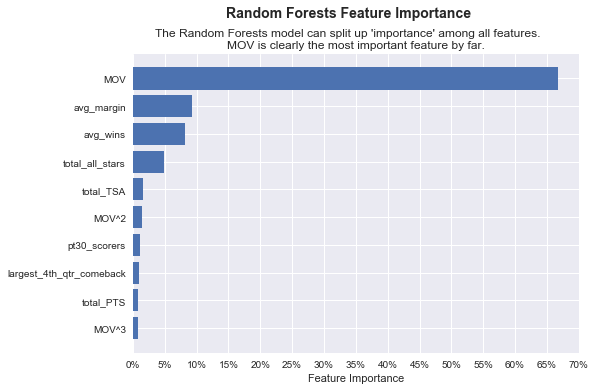

<IPython.core.display.Javascript object>

In [547]:
forest_importance = Series(
    dict(zip(all_variables, forest_model.feature_importances_))
).sort_values(ascending=False)[:10]

fig, ax = plt.subplots()

ax.barh(forest_importance.index, forest_importance.values)
xticks = range(0, 75, 5)
ax.set(
    title="The Random Forests model can split up 'importance' among all features. \
    \nMOV is clearly the most important feature by far.",
    ylabel="",
    xlabel="Feature Importance",
    xticks=[i / 100 for i in xticks],
    xticklabels=[str(i) + "%" for i in xticks],
)
fig.suptitle("Random Forests Feature Importance", fontweight="bold", fontsize=14, y=1)

ax.invert_yaxis()

plt.savefig("forest.png", dpi=400, bbox_inches="tight")